In [1]:
import json
import shelve
from tqdm import tqdm
import random
import csv

import matplotlib.pyplot as plt

from data.ag.action_genome import AG, AGViewer
from util.graph_utils import check_edge_exists

VERBS = [
    "awaken",
    "close",
    "cook", 
    "dress",
    "drink",
    "eat",
    "fix",
    "grasp", 
    "hold",
    #"laugh",
    "lie",
    "make",
    "open",
    "photograph",
    "play",
    "pour",
    "put",
    "run",
    "sit",
    #"smile",
    #"sneeze",
    "snuggle",
    "stand",
    "take",
    "talk",
    "throw",
    "tidy",
    "turn",
    "undress",
    "walk",
    "wash",
    "watch",
    "work"
]

root = '/data/Datasets/ag/'
subset_file = 'data/ag/subset_shelve'
split_file = 'data/ag/split_train_val_test.json'


In [2]:

#ag = AG(root, no_img=True, split=None, subset_file=subset_file, verb_whitelist=VERBS)
ag = AG(root, no_img=False, split='val', split_file=split_file, subset_file=subset_file, verb_whitelist=VERBS)
#ag = AG(root, split=None, subset_file=None, verb_blacklist=['smile', 'laugh', 'sneeze']) #view the full dataset
#ag = AG(root, split='test', subset_file='data/ag/subset_shelve') #view the test split dataset
#ag = AG(root, no_img=True, split='train', subset_file='data/ag/subset_shelve', verb_whitelist=VERBS) #view the test split dataset


split: val | length: 1597


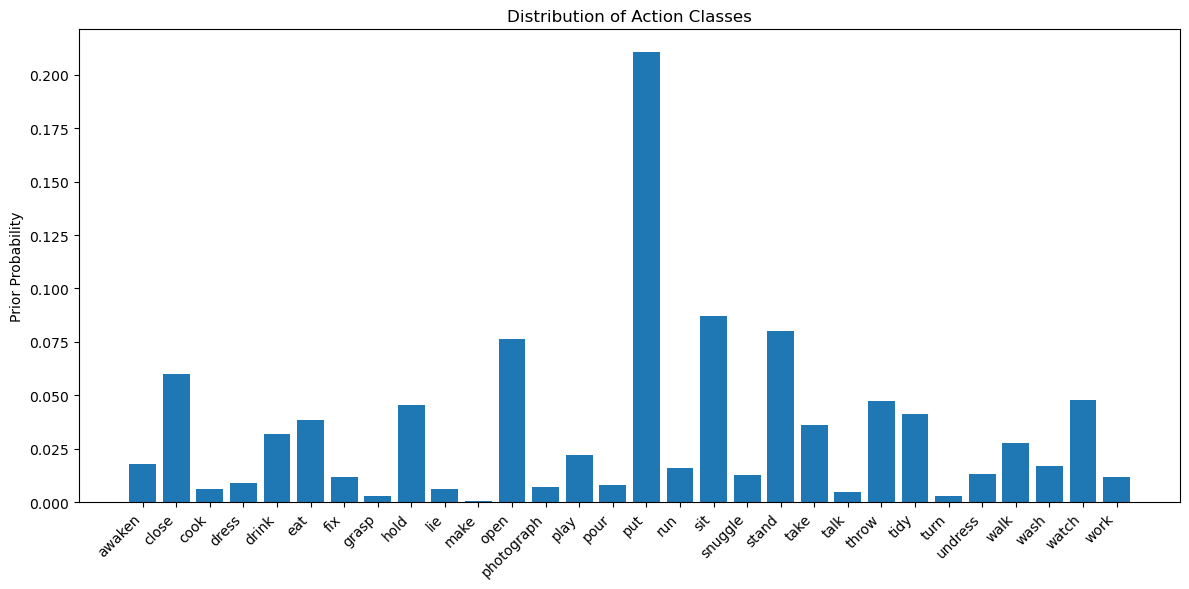

30


In [13]:
plt.figure(figsize=(12,6))
plt.bar(ag.verb_classes, ag.verb_priors)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Action Classes')
plt.ylabel('Prior Probability')
plt.tight_layout()
plt.show()
print(len(ag.verb_priors))

Applying learned rules-----------------
DOQ9Y.mp4/000137.png_0


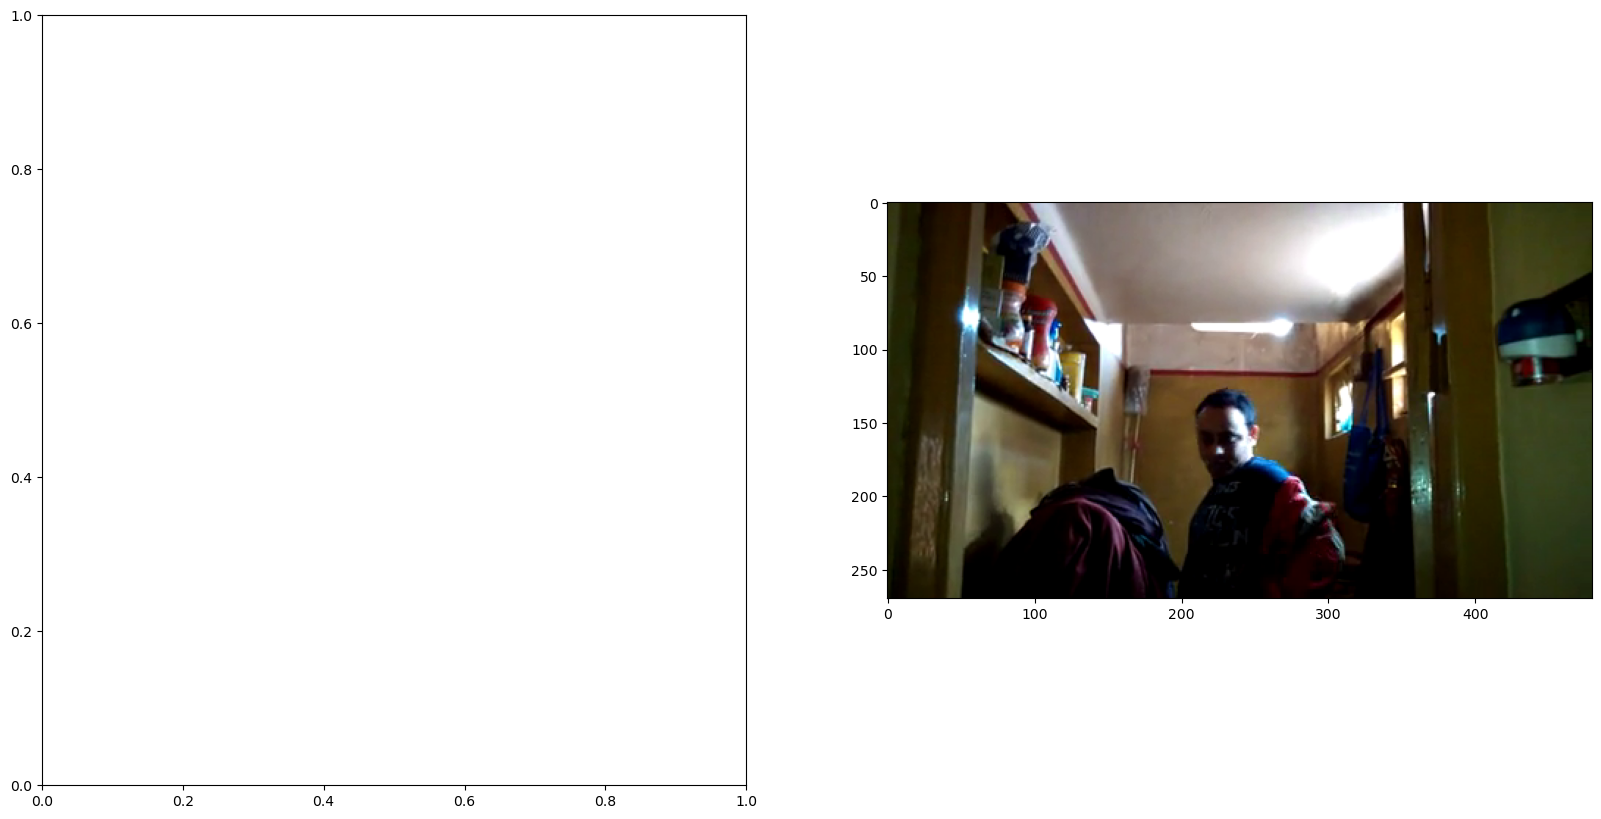

prediction: undress
top 5 predictions: ['undress', 'dress', 'hold', 'sit', 'put']
top 5 predictions(neural): ['undress', 'play', 'dress', 'watch', 'turn']
top 5 predictions(rule prior): ['undress', 'dress', 'hold', 'put', 'stand']
ground truth: hold
action: Holding some clothes
EXPLANATION==================================
The preconditions for the following actions were satisfied:
dress:-	dress_target(A):- on_the_side_of(B,A),clothes(B).
	dress_target(A):- in_front_of(B,A),clothes(B).
	dress_target(A):- shoe(B),holding(A,B).
hold:-	hold_target(A):- not_contacting(A,B),shoe(B),in_front_of(B,A).
	hold_target(A):- not_contacting(A,B),cup_glass_bottle(B),in_front_of(B,A).
	hold_target(A):- not_contacting(A,B),on_the_side_of(B,A),broom(B).
	hold_target(A):- not_contacting(A,B),on_the_side_of(B,A),book(B).
	hold_target(A):- looking_at(A,B),on_the_side_of(B,A),box(B).
	hold_target(A):- looking_at(A,B),not_contacting(A,B),dish(B).
	hold_target(A):- looking_at(A,B),not_contacting(A,B),food(B).

In [6]:
import os
from models.action_anticipator import ActionAnticipator 
import torch
from torchvision import transforms as T
from util.visualize import show_pyg_graph
from torch_geometric.data import Data, Batch
from util.rule_utils import apply_rules

ckpt_path = 'runs/deafening-capital/checkpoints/epoch=28-val_acc=0.22.ckpt'

model = ActionAnticipator.load_from_checkpoint(ckpt_path)
model.constraint_mode = 'soft'
model.constraint_weight = 20
model.cuda()


def explain(model, img, sg, truth_values, constraints, out):
    print('The following actions appear likely at first glance:')
    print([ag.verb_classes[i] for i in top_k_neural_out])
    print('Based on our prior knowledge, given that these conditions are satisfied, the following actions are likely:')
    print([ag.verb_classes[i] for i in top_k_rule_prior])
    print('Combining our prior knowledge from the rules and the neural network, we predict that the following actions are most likely to be taken after this state:')
    print([ag.verb_classes[i] for i in top_k])
    pass
    

def test_model(model, ag, idx):
    id, img, sg, action, constraint, truth_value = ag[idx]
    print(id)
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    #show_pyg_graph(sg, ag.object_classes, ag.relationship_classes, layout='circular', ax=axs[0])
    axs[1].imshow(img)
    plt.show(fig)

    resized_image = ag.im_transform(img)
    resized_image = resized_image.unsqueeze(0).cuda()
    sg = sg.cuda()
    constraint = constraint.cuda()
    truth_value = truth_value.cuda()

    out, neural_out, rule_prior = model.predict_single(resized_image, sg, constraint, truth_value)
    out_class = torch.argmax(out, dim=1)
    k = 5
    top_k = torch.topk(out, k=k).indices[0].tolist()
    top_k_neural_out = torch.topk(neural_out, k=k).indices[0].tolist()
    top_k_rule_prior = torch.topk(rule_prior, k=k).indices.tolist()

    print('prediction:', ag.verb_classes[out_class])
    print('top 5 predictions:', [ag.verb_classes[i] for i in top_k])
    print('top 5 predictions(neural):', [ag.verb_classes[i] for i in top_k_neural_out])
    print('top 5 predictions(rule prior):', [ag.verb_classes[i] for i in top_k_rule_prior])
    print('ground truth:', ag.verb_classes[ag.action_verb_obj_map[action][0]])
    print('action:', ag.action_classes[action])

    #explain
    print('EXPLANATION==================================')

    rules_file = 'prolog/ag/learned_rules/debug_rules.json'
    with open(rules_file, 'r') as f:
        rules_dict = json.load(f)
    print('The preconditions for the following actions were satisfied:')
    for i in range(len(truth_value)):
        ith_verb = ag.verb_classes[i]
        if rules_dict[ith_verb] is None:
            print(ith_verb + ':-\t True' )
        elif truth_value[i] > 0.5:
            rules_str = '\n\t'.join(rules_dict[ith_verb][0])
            print(ith_verb + ':-\t' + rules_str)


constraints, truth_values = apply_rules('debug_rules', 'prolog/ag/learned_rules', 
        os.path.join('prolog/ag/', f'val_bk.pl'),
        len(ag), ag.verb_classes,
        mode='soft',
        recall_threshold=0.8,
        priors=ag.verb_priors)
ag.constraints = constraints
ag.truth_values = truth_values
test_model(model, ag, 0)

In [ ]:
#for a, (v, o) in sorted(ag.action_verb_obj_map.items(), key=lambda x: x[1][0]):
for a, (v, o) in ag.action_verb_obj_map.items():
    action = ag.action_classes[a]
    verb = ag.verb_classes[v]
    obj = None if o is None else ag.object_classes[o]
    print(action, f'({verb}, {obj})')

INDEX: 0
LABEL: UNMARKED
ACTION: Holding some clothes
VERB-OBJ: hold clothes
VIDEO-FRAME-ACTION ID: DOQ9Y.mp4/000137.png_0
[('person', 'not_looking_at', 'clothes'), ('clothes', 'on_the_side_of', 'person'), ('person', 'wearing', 'clothes')]


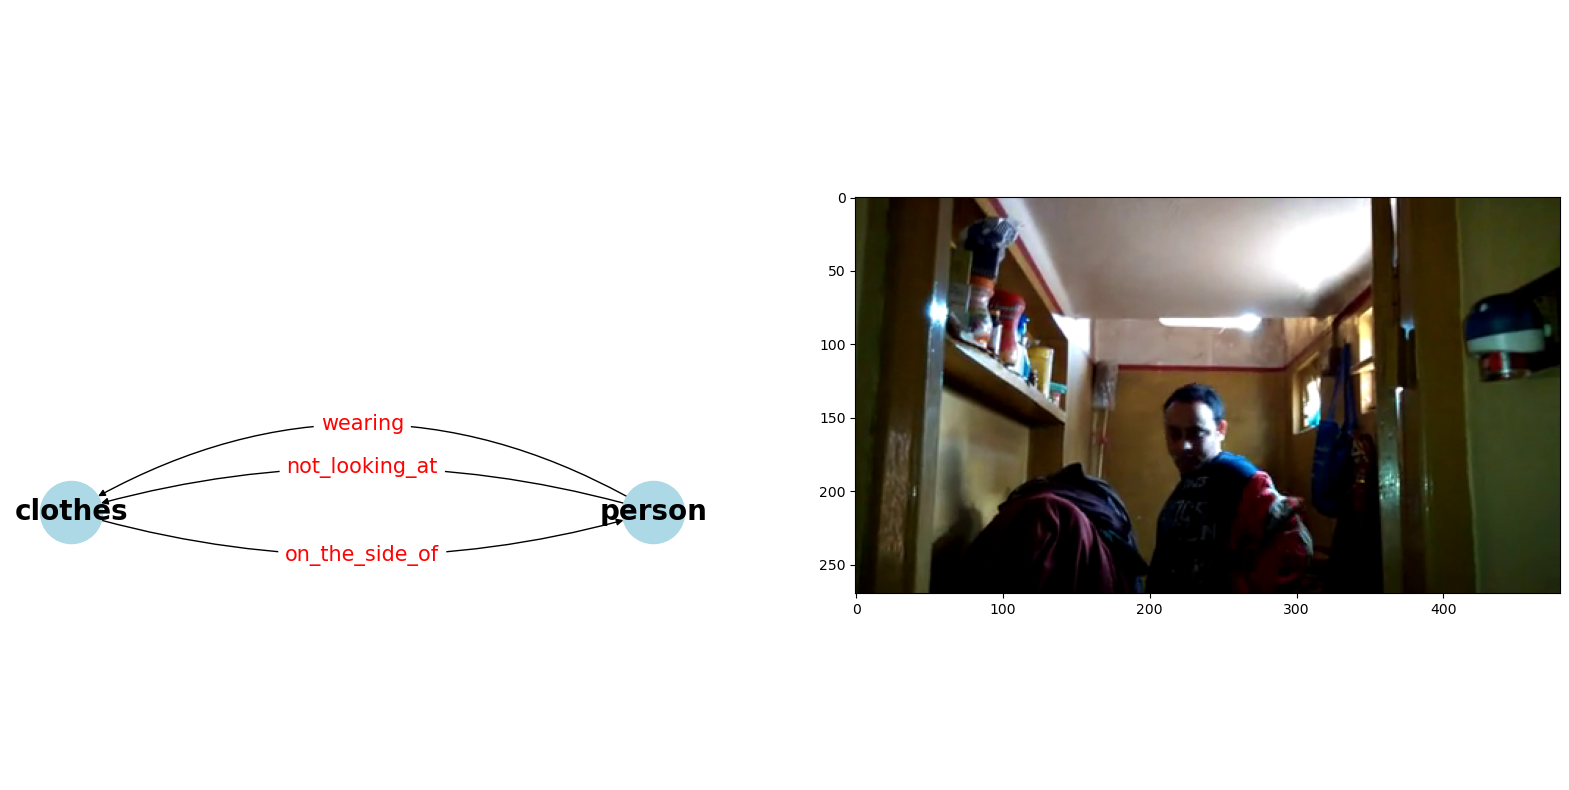

In [11]:

with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict)
    agview.view(0)
    while True:
        answer = input(f"{agview.message}current search key : {str(agview.key)}")
        new_idx = agview.process_command(answer)
        if new_idx is not None:
            agview.view(new_idx)
        else:
            break


In [ ]:
%autoreload
idx_list = list(range(len(ag)))
random.shuffle(idx_list)

correct_count = 0
incorrect_count = 0
with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict, human_test=True)
    for idx in idx_list:
        _, verb = agview.view(idx)
        if correct_count + incorrect_count > 0:
            accuracy = correct_count / (correct_count + incorrect_count)
        else:
            accuracy = 0
        answer = input(f"correct: {correct_count}, incorrect: {incorrect_count}, accuracy: {accuracy}")
        if answer == 'q':
            break
        if answer == verb:
            correct_count += 1
            print('CORRECT' + verb)
        else:
            incorrect_count += 1
            print('INCORRECT' + verb)


In [ ]:
#Check for overlap between train, val, and test splits
with open('data/ag/split_train_val_test.json', 'r') as f:
    split_dict = json.load(f)
    train_ids = set(split_dict['train'])
    val_ids = set(split_dict['val'])
    test_ids = set(split_dict['test'])
    
    # Check for overlap
    train_val_overlap = train_ids.intersection(val_ids)
    train_test_overlap = train_ids.intersection(test_ids)
    val_test_overlap = val_ids.intersection(test_ids)

    if len(train_val_overlap) > 0 or len(train_test_overlap) > 0 or len(val_test_overlap) > 0:
        print(f"Warning: Found overlapping IDs between train and val splits")
    else:
        print("No overlap found between train and test splits")


In [ ]:

VERBS = [
    "awaken",
    "close",
    "cook", 
    "dress",
    "drink",
    "eat",
    "fix",
    "grasp", 
    "hold",
    #"laugh",
    "lie",
    "make",
    "open",
    "photograph",
    "play",
    "pour",
    "put",
    "run",
    "sit",
    #"smile",
    #"sneeze",
    "snuggle",
    "stand",
    "take",
    "talk",
    "throw",
    "tidy",
    "turn",
    "undress",
    "walk",
    "wash",
    "watch",
    "work"
]

ag = AG(root, no_img=True, split=None, subset_file=subset_file, verb_whitelist=VERBS)
print(ag.verb_classes)
print(ag.action_classes)
print(ag.action_verb_obj_map)


In [ ]:
freqs = ag.verb_label_counts
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(freqs)), ag.verb_classes, rotation=45, ha='right')
plt.title('Distribution of Verb Classes')
plt.xlabel('Verb')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
import pickle

with open(root+'annotations/object_bbox_and_relationship.pkl', 'rb') as f:
    object_annotations = pickle.load(f)

In [ ]:
object_annotations['AZC1I.mp4/000453.png']

In [ ]:
s = 'phone/camera/book'
s.replace('/', '_')

In [ ]:
import numpy as np
from pyswip import Prolog

ag = AG(root, no_img=True, split='train', subset_file=subset_file, verb_whitelist=VERBS)

def evaluate_rule(verb):
    rules_file = 'outputs/ag/debug_rules.pl'
    bk_file = 'prolog/ag/train_bk.pl'

    _ = Prolog()

    Prolog.consult(rules_file)
    Prolog.consult(bk_file)

    TP, FP, TN, FN = 0, 0, 0, 0

    for i in tqdm(range(len(ag))):
        _, _, _, action, _ = ag[i]

        label_verb, _ = ag.action_verb_obj_map[action]

        q = Prolog.query(f'{verb}_target(x{i}_0)')
        satisfied = False
        for q in q:
            satisfied = True
            break

        if satisfied and label_verb == verb:
            TP += 1
        elif satisfied and label_verb != verb:
            FP += 1
        elif not satisfied and label_verb == verb:
            FN += 1
        else:
            TN += 1

    return TP, FP, TN, FN

evaluate_rule('close')
